In [1]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
%matplotlib inline
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:80% !important; }</style>")) 

In [2]:
import os; import sys
cwd = os.getcwd()
path = os.path.join(cwd, '..', 'movie_recommender')
if not path in sys.path:
    sys.path.append(path)
del cwd, path

from similarity import SimilarityPredictions
from collaborative_filtering import CollaborativeFiltering
from content_filtering import ContentFiltering

# Load Tags Data

In [3]:
# Load index mapping 
with open('../data/movie_to_idx.pkl', 'rb') as handle:
    movie2idx = pickle.load(handle)

In [4]:
#load tags and ratings data
cwd = os.getcwd()
tags = pd.read_csv(os.path.join(cwd, "..", "data", "tags.csv"))
print("{} unique movies in tags.csv".format(len(tags.movieId.unique())))
ratings = pd.read_csv(os.path.join(cwd, "..", "data", "ratings.csv"))
ratings = ratings.drop_duplicates('movieId')
print("{} unique movies in ratings.csv".format(len(ratings.movieId.unique())))

19545 unique movies in tags.csv
26744 unique movies in ratings.csv


In [5]:
#map movie index for tags data
tags = pd.merge(tags, ratings, on="movieId", how="right")
tags.movieId = tags.movieId.apply(lambda x: movie2idx[x])
print("{} unique movies in tags.csv".format(len(tags.movieId.unique())))
print(tags.shape)
tags.head()

26744 unique movies in tags.csv
(472537, 7)


,userId_x,movieId,tag,timestamp_x,userId_y,rating,timestamp_y
0,18.0,3135,Mark Waters,1.240597e+09,103,3.5,1055018362
1,66193.0,3135,naive,1.294446e+09,103,3.5,1055018362
2,70201.0,3135,Mark Waters,1.308333e+09,103,3.5,1055018362
3,89274.0,3135,Freddie Prinze Jr.,1.375164e+09,103,3.5,1055018362
4,65.0,639,dark hero,1.368150e+09,8,3.0,833981834


In [6]:
#map movie index for movie data
movies = pd.read_csv(os.path.join(cwd, "..", "data", "movies.csv"))
print("{} unique movies in movies.csv".format(len(movies.movieId.unique())))
print("{} unique movies in ratings.csv".format(len(ratings.movieId.unique())))

movies = pd.merge(movies, ratings, on="movieId", how="inner")
movies.movieId = movies.movieId.apply(lambda x: movie2idx[x])
print("{} unique movies in movies.csv".format(len(movies.movieId.unique())))

movies.set_index('movieId', inplace=True)
movies['genres'] = movies['genres'].str.replace(pat="|", repl=" ")
movies['genres'] = movies['genres'].str.replace(pat="-", repl="")
movies.query('title == "Primer (2004)"')

27278 unique movies in movies.csv
26744 unique movies in ratings.csv
26744 unique movies in movies.csv


,title,genres,userId,rating,timestamp
movieId,,,,,
3006,Primer (2004),Drama SciFi,96,4.5,1402187423


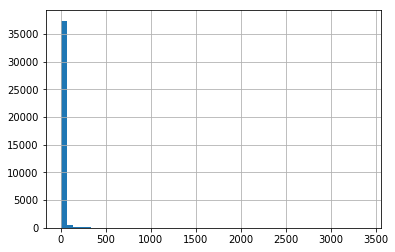

In [7]:
tags.tag.value_counts().hist(bins=50)

In [8]:
#create documents from tags
tags.fillna("", inplace=True)
tags = pd.DataFrame(tags.groupby('movieId')['tag'].apply(lambda x: "{%s}" % ' '.join(x)))
tags.reset_index(inplace=True)
movie_id = tags.movieId
print("There are {} unique movies".format(len(movie_id)))
tags.sample(10)

There are 26744 unique movies


,movieId,tag
1825,1825,{Watched 3D adapted from:book series bellicose...
15993,15993,{}
22613,22613,{}
17000,17000,{Mitsuo Yanagimachi}
25641,25641,{}
461,461,{sport:bobsledding bobsled Jamaica Olympics sp...
19860,19860,{}
1954,1954,{delusion delusional dork people emotional fam...
1725,1725,{Penny Marshall military}
23951,23951,{}


In [9]:
# add genres to document
tags = pd.merge(movies, tags, left_index=True, right_on='movieId', how='right')
tags['document'] = tags[['tag', 'genres']].apply(lambda x: ' '.join(x), axis=1)
tags.head(3)

,title,genres,userId,rating,timestamp,movieId,tag,document
0,Jumanji (1995),Adventure Children Fantasy,1,3.5,1112486027,0,{time travel adapted from:book board game chil...,{time travel adapted from:book board game chil...
1,"City of Lost Children, The (Cité des enfants p...",Adventure Drama Fantasy Mystery SciFi,1,3.5,1112484676,1,{children Santa Claus dystopia abused children...,{children Santa Claus dystopia abused children...
2,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery SciFi Thriller,1,3.5,1112484819,2,{post-apocalyptic psychology time travel Brad ...,{post-apocalyptic psychology time travel Brad ...


In [10]:
tags.query('title == "Zodiac (2007)"').document.values

array(["{serial killer based on a true story serial killer; based on a true story long obsession serial killer based on a true story serial killer crime David Fincher investigation investigative journalism Jake Gyllenhaal long Mark Ruffalo Robert Downey Jr. serial killer slow Too long based on a true story detective investigation Journalist obsession David Fincher Jake Gyllenhaal Mark Ruffalo Robert Downey Jr bad ending Jake Gyllenhaal length Robert Downey Jr adapted from:true story based on a true story ChloÃ« Sevigny David Fincher detective great character development investigative journalism Jake Gyllenhaal John Carroll Lynch long Mark Ruffalo mind games obsession Robert Downey Jr. serial killer police based on a true story detective investigation police serial killer based on a true story Robert Downey Jr serial killer Too long true story cinematography David Fincher stylized investigative journalism obsession police police based on a true story based on a true story crime obsessio

In [11]:
tags.query('movieId == 19849')

,title,genres,userId,rating,timestamp,movieId,tag,document
19849,"Waiting Game, The (2000)",Comedy,29879,2.5,1161368462,19849,{},{} Comedy


# Item-User Collaborative Filtering

In [12]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn import cross_validation as cv

/anaconda3/envs/my-movie-recommender/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
ratings = pd.read_csv(os.path.join(cwd, "..", "data", "ratings.csv"))
movies = pd.read_csv(os.path.join(cwd, "..", "data", "movies.csv"))
ratings = pd.merge(movies, ratings, on="movieId", how="right")
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])
print(ratings.shape)
print("There are {} users.".format(len(ratings.userId.unique())))
print("There are {} movies.".format(len(ratings.movieId.unique())))
ratings.head()

(20000263, 6)
There are 138493 users.
There are 26744 movies.


,movieId,title,genres,userId,rating,timestamp
0,227,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,944919407
1,227,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0,858275452
2,227,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,833981871
3,227,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0,943497887
4,227,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5,1230858821


In [ ]:
train, test = cv.train_test_split(ratings, test_size=0.2)

#drop users and movies from test that aren't in train
c = list(set(test.movieId).intersection(train.movieId))
test = test[test['movieId'].isin(c)]
c = list(set(test.userId).intersection(train.userId))
test = test[test['userId'].isin(c)]

#Put those observations back in train
t = test.index
train = ratings.loc[~ratings.index.isin(t)]

print("There are {} observations in train.".format(train.shape[0]))
print("There are {}  observations in test.".format(test.shape[0]))
train.head()

In [ ]:
train = train.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
user_index = train.index.tolist()
movie_index = train.columns.tolist()
print(train.shape)
train.head()

In [ ]:
train = csr_matrix(train.values)
train

In [ ]:
U, sigma, Vt = svds(train, k=100) # k is the number of factors
sigma = np.diag(sigma)

In [ ]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

In [ ]:
predicted_ratings = pd.DataFrame(predicted_ratings, index=user_index, columns=movie_index)
predicted_ratings = predicted_ratings.astype('int')
predicted_ratings.head(4)

In [ ]:
predicted_ratings.to_pickle("collaborative_item_to_user_model.pkl")

In [ ]:
predicted_ratings.loc[1].max()

In [ ]:
test

In [ ]:
#Find a popular movie and look at precision and recall
#Find a niche movie and look at precision and recall

#Find average precision and recall for the head
#Find average precision and recall for the tail. 

#make mar@k and map@k plots